# Softmax

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

In [47]:
import random
import numpy as np
from utils.data_utils import get_CIFAR10_data
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cifar10_dataset = get_CIFAR10_data(cifar10_dir='./datasets/cifar-10-batches-py')

X_train = cifar10_dataset['X_train']
y_train = cifar10_dataset['y_train']
X_dev = cifar10_dataset['X_dev']
y_dev = cifar10_dataset['y_dev']
X_val = cifar10_dataset['X_val']
y_val = cifar10_dataset['y_val']
X_test = cifar10_dataset['X_test']
y_test = cifar10_dataset['y_test']

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Dev data shape: ', X_dev.shape)
print('Dev labels shape: ', y_dev.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (49000, 32, 32, 3)
Training labels shape:  (49000,)
Dev data shape:  (5000, 32, 32, 3)
Dev labels shape:  (5000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


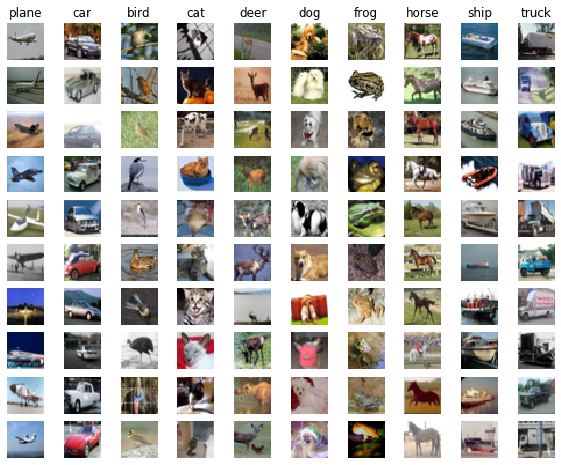

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

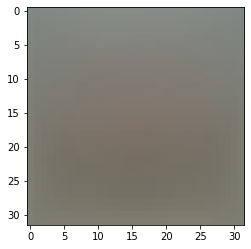

In [3]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [4]:
# subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [5]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_dev.shape, X_val.shape, X_test.shape)

(49000, 3072) (5000, 3072) (1000, 3072) (10000, 3072)


In [6]:
# append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (10000, 3073) (5000, 3073)


## Softmax Classifier

Your code for this section will all be written inside **classifiers/softmax.py**. 


In [8]:
# First implement the naive softmax loss function with nested loops.
# Open the file classifiers/softmax.py and implement the
# softmax_loss_naive function.

from classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.372908
sanity check: 2.302585


Why do we expect our loss to be close to -log(0.1)?

In [9]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from utils.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.646841 analytic: -2.646841, relative error: 6.471376e-10
numerical: 2.116284 analytic: 2.116284, relative error: 1.538839e-08
numerical: 2.751923 analytic: 2.751923, relative error: 3.500966e-08
numerical: -1.923771 analytic: -1.923771, relative error: 1.497321e-08
numerical: 0.313219 analytic: 0.313219, relative error: 1.296594e-07
numerical: 0.246426 analytic: 0.246426, relative error: 1.641681e-07
numerical: 5.584855 analytic: 5.584855, relative error: 1.098419e-08
numerical: -0.188349 analytic: -0.188349, relative error: 1.663229e-07
numerical: -0.930847 analytic: -0.930847, relative error: 3.265111e-08
numerical: -3.301902 analytic: -3.301901, relative error: 1.703710e-08
numerical: 2.226007 analytic: 2.226007, relative error: 2.243422e-08
numerical: -1.484203 analytic: -1.484203, relative error: 9.703915e-09
numerical: -2.522009 analytic: -2.522009, relative error: 2.673650e-08
numerical: 0.550134 analytic: 0.550134, relative error: 3.478482e-08
numerical: -0.441535

In [13]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.372908e+00 computed in 1.375771s
vectorized loss: 2.372908e+00 computed in 0.289608s
Loss difference: 0.000000
Gradient difference: 0.000000


In [14]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, 
                      learning_rate=1e-7, reg=3e4,
                      num_iters=1000, batch_size=256, 
                      verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1000: loss 935.401686
iteration 100 / 1000: loss 280.800077
iteration 200 / 1000: loss 85.558234
iteration 300 / 1000: loss 27.004138
iteration 400 / 1000: loss 9.608924
iteration 500 / 1000: loss 4.379751
iteration 600 / 1000: loss 2.792097
iteration 700 / 1000: loss 2.276316
iteration 800 / 1000: loss 2.154914
iteration 900 / 1000: loss 2.168152
That took 3.375528s


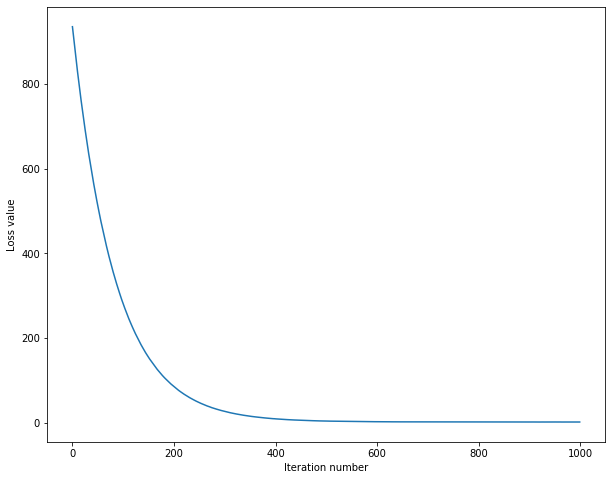

In [15]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [16]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.322796
validation accuracy: 0.339000


In [17]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        softmax = Softmax()
        softmax.train(X_train, y_train, 
                      learning_rate=learning_rate, reg=regularization_strength,
                      num_iters=1500, verbose=False)

        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)

        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)

        if best_val < val_accuracy:
            best_val = val_accuracy
            best_softmax = softmax
    
        results[(learning_rate, regularization_strength)] = (train_accuracy, val_accuracy)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.333571 val accuracy: 0.346000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.308408 val accuracy: 0.317000
lr 5.000000e-07 reg 2.500000e+04 train accuracy: 0.324653 val accuracy: 0.349000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.297551 val accuracy: 0.317000
best validation accuracy achieved during cross-validation: 0.349000


In [18]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.326400


Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

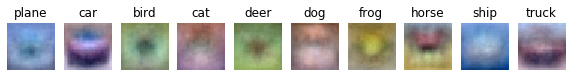

In [19]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(1, 10, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:,:,:,i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

Well Done